In this Notebook the interpretation methods, Input-Output Gradient and Activation Maximisation are applied to the 64-16-4 linear model.
The Activation Maximisation is adopted from Clemens Rohling:https://github.com/clemensuniH/Sea_Ice

In [1]:
import xarray as xr
import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from copy import deepcopy
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [2]:
from modules import *

/Users/ferdinand/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv2d(input, weight, bias, self.stride,


# Gradient

### 64 16 4

In [3]:
# Load the NetCDF file using netCDF4
file_path = 'Data/combined_dataset.nc'

# Prepare datasets and loader
train_loader, val_loader, test_loader, train_x_stats, train_y_stats, val_x_stats, val_y_stats, test_x_stats, test_y_stats = prepare_datasets_L(file_path, batch_size=64, train_ratio=0.7, val_ratio=0.15, shuffle = False, info=False)

# Initialize model
Model = LinModel( n_inputs= 180*90, nodes_per_layer=[64,16,4], use_dropout=False, use_batchnorm=True)

checkpoint_path = 'trained_models/LinModel_64_16_4_HR_L.pth'

# Load model
checkpoint = torch.load(checkpoint_path)
Model.load_state_dict(checkpoint['vis_model_state_dict'])

Model.eval()

LinModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16200, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=4, bias=True)
    (7): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
    (9): Linear(in_features=4, out_features=1, bias=True)
  )
)

tensor(2100.)
tensor([[2092.6396]], grad_fn=<AddBackward0>)
Gradients: tensor([[[-4.4460e-05, -4.8351e-05, -6.7063e-05,  ..., -2.8208e-05,
          -2.8373e-05, -3.2145e-05],
         [ 4.1939e-05,  2.7733e-05,  1.6603e-05,  ...,  2.8350e-05,
           3.2421e-05,  4.1931e-05],
         [ 7.8984e-05,  5.3285e-05,  5.5626e-05,  ...,  8.2966e-05,
           8.9746e-05,  9.1715e-05],
         ...,
         [ 3.0588e-05,  3.0439e-05,  3.3575e-05,  ...,  2.3694e-05,
           2.4822e-05,  2.8257e-05],
         [ 2.4132e-05,  2.4157e-05,  2.6052e-05,  ...,  2.0321e-05,
           2.8391e-05,  2.3944e-05],
         [ 1.4525e-05,  1.8890e-05,  2.0300e-05,  ...,  1.3152e-05,
           1.3763e-05,  1.2980e-05]]])


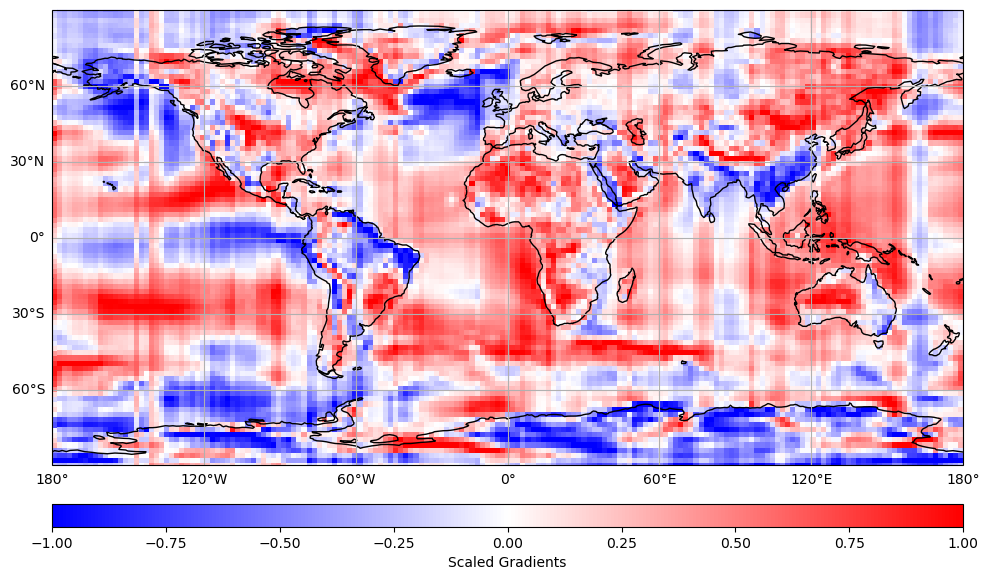

In [4]:
# Pick output input pair
for inputs, targets in val_loader:
    break

year = targets[54] * val_y_stats[1] + val_y_stats[0]
print(year)

# Select a single input sample 
single_input = inputs[54].unsqueeze(0)  # Add batch dimension
single_input.requires_grad = True

# Forward pass
output = Model(single_input)
print(output * val_y_stats[1] + val_y_stats[0])

# Backward pass
output.sum().backward()  # Use sum to handle non-scalar output

# Get the gradients
gradients = single_input.grad

print("Gradients:", gradients)

# Plotting gradients
weights = gradients.cpu().numpy()
weights = weights.reshape(90, 180)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_weights = scaler.fit_transform(weights)

lat = np.linspace(-90, 90, 90)
lon = np.linspace(0, 360, 180)

# Create a meshgrid for latitude and longitude
lon, lat = np.meshgrid(lon, lat)

# Scaled weights as data
data = scaled_weights

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
c = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap='bwr')

# Add coastlines and gridlines
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

cbar = plt.colorbar(c, ax=ax, orientation='horizontal',  pad=0.05, aspect=40)
cbar.set_label('Scaled Gradients')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

# Input Max

In [5]:
import torch
import torch.optim as optim
from tqdm import tqdm

# this is adopted from https://github.com/clemensuniH/Sea_Ice

def maximize_output_for_target(model, target_value, input_shape, num_steps=1000, lr=0.1):
    """
    Generates an artificial input that maximizes the model output towards a specific target value.

    Parameters:
    model (nn.Module): The neural network model.
    target_value (float): The target value to maximize the model output towards.
    input_shape (tuple): The shape of the input tensor.
    num_steps (int): The number of optimization steps. Default is 1000.
    lr (float): The learning rate for the optimizer. Default is 0.1.

    Returns:
    input_data (torch.Tensor): The optimized input tensor.
    """
    # Initialize a random input tensor with the specified shape
    input_data = torch.randn(input_shape, requires_grad=True, dtype=torch.float32)

    # Define the optimizer
    optimizer = optim.Adam([input_data], lr=lr)

    # Optimization loop
    for step in tqdm(range(num_steps)):
        optimizer.zero_grad()

        # Forward pass
        output = model(input_data)

        # Compute the loss as the negative difference from the target value
        loss = -(output - target_value).abs().mean()

        # Backward pass
        loss.backward()
        optimizer.step()

    return input_data



### 64 16 4

In [6]:
# Load the NetCDF file using netCDF4
file_path = 'Data/combined_dataset.nc'

# Prepare datasets and loader
train_loader, val_loader, test_loader, train_x_stats, train_y_stats, val_x_stats, val_y_stats, test_x_stats, test_y_stats = prepare_datasets_L(file_path, batch_size=64, train_ratio=0.7, val_ratio=0.15, shuffle = False, info=False)

# Initialize model
Model = LinModel( n_inputs= 180*90, nodes_per_layer=[64,16,4], use_dropout=False, use_batchnorm=True)

checkpoint_path = 'trained_models/LinModel_64_16_4_HR_L.pth'

# Load model
checkpoint = torch.load(checkpoint_path)
Model.load_state_dict(checkpoint['vis_model_state_dict'])
Model.eval()

LinModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16200, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=4, bias=True)
    (7): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
    (9): Linear(in_features=4, out_features=1, bias=True)
  )
)

/var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/ipykernel_20939/557636336.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_value)  # Example target value


Target value: tensor(2100.)


100%|██████████| 30000/30000 [00:51<00:00, 579.92it/s]


Optimized input: tensor([[[-5.3348, -5.4708, -7.2275,  ..., -5.2908, -4.5115, -5.1534],
         [-5.3074, -6.4206, -6.6157,  ..., -5.4216, -5.8209, -5.9570],
         [-6.2802, -8.6919, -7.2417,  ..., -6.0896, -8.9137, -6.3409],
         ...,
         [-4.8655, -3.8117, -3.8068,  ..., -2.7803, -3.7384, -7.1665],
         [-2.8860, -1.7635, -3.1202,  ..., -1.7694, -4.1870, -3.0662],
         [-2.2029, -4.1155, -4.4477,  ..., -3.0156, -1.7639, -5.4575]]],
       requires_grad=True)


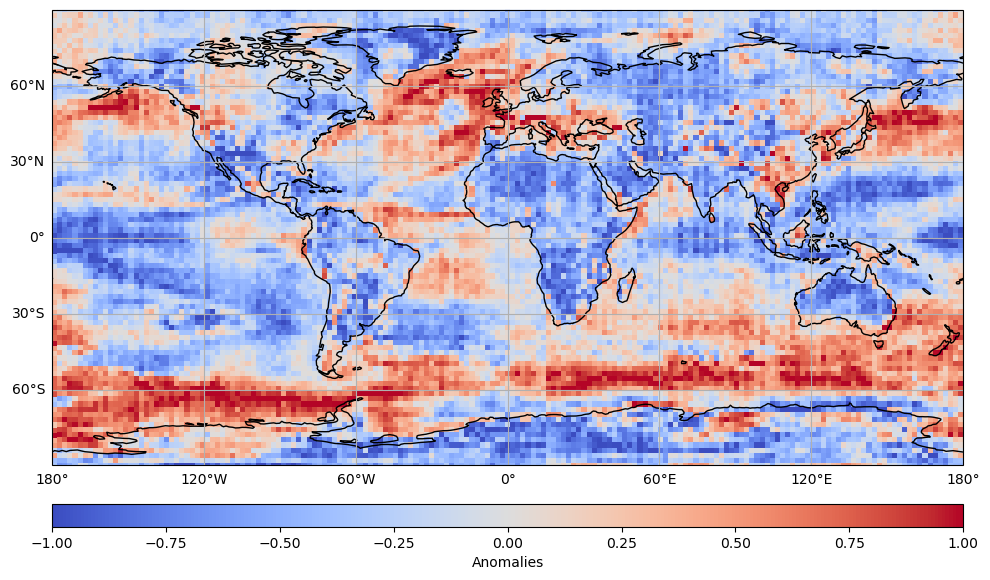

In [7]:
# Artificial input
input_shape = (1, 90, 180)  # Example input shape

# Setting the target value and normalizing it
target_value = (2100 - train_y_stats[0]) / train_y_stats[1] 

# Example target value
torch.tensor(target_value)  

print("Target value:", target_value*train_y_stats[1] + train_y_stats[0])

# Optimize the input
optimized_input = maximize_output_for_target(Model, target_value, input_shape, num_steps=30000, lr=0.001)

print("Optimized input:", optimized_input)

# Plotting optimized input
weights = optimized_input.detach().numpy()
weights = weights.reshape(90, 180)
scaler = MinMaxScaler(feature_range=(-1, 1) )
scaled_weights = scaler.fit_transform(weights)

lat = np.linspace(-90, 90, 90)
lon = np.linspace(0, 360, 180)

# Create a meshgrid for latitude and longitude
lon, lat = np.meshgrid(lon, lat)

# Scaled weights as data
data = scaled_weights

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
c = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap='coolwarm')

# Add coastlines and gridlines
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

cbar = plt.colorbar(c, ax=ax, orientation='horizontal',  pad=0.05, aspect=40)
cbar.set_label('Anomalies')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()